# Modelling Loss Given Default (LGD) with Generalized Autoregressive Score Models (GAS)

Alexandru Giurca, VU Amsterdam, December 2019

## 1. Introduction

In the context of credit portfolio losses, loss given default (LGD) is the proportion of the exposure that will be lost if a default occurs. Uncertainty regarding the actual LGD is an important source of credit portfolio risk in addition to default risk. Therefore the LGD is is a key ingredient of current financial risk management and regulation. Precise evaluation of this parameter is important not only for bank to calculate their regulatory capital but also for investors to price risky bonds and credit derivatives. 

### 1.1 Problem of actual Modelling Approaches

As the loss given default rates are reported in percentage terms, it is plausible to model these with a beta distribution. The beta distribution is well-known to be very flexible, modeling quantities constrained in the interval $[0,1]$. Depending on the choice of parameters, the probability density function can be unimodal, U-shaped, J-shaped or uniform. In practice, in both CreditMetrics and KMV Portfolio Manager, for example, the uncertainty in the LGD rates of defaulted obligors is assumed to be a **static** beta random variable independent for each obligor. 

Such a modeling strategy is highly risky if the properties of LGDs actually vary over time. For example, losses could be on average higher in situations where default risk is also higher, thus exacerbating total expected losses defined as the probability of default times the LGD. If such time-variation is a property of the data, it should be modeled and would typically result in higher capital requirements for financial instututions.

### 1.2 Aim 

Our goal is to implement a model that improves on current industry standards and is (relatively) easy to implement and estimate: **Generalized Autoregressive Score (GAS) Model** for a **time-varying beta distribution**. GAS models (alternative names: score-driven model, dynamic conditional score (DCS)) are a flexible class of *observation driven time-varying parameter* models characterized by a parametric conditional observation density - parameters are deterministic functions of lagged dependent variables as well as contemporaneous and lagged exogenous variables. As their likelihood is available in closed form, maximum likelihood based estimation and inference is straightforward.

GAS models are of relevance for the modeling of all types of time series data. It does not matter whether they are real-valued, integer-valued, (0, 1)-bounded or strictly positive, as long as there is a conditional density for which the score function and the Hessian are well-defined. The practical relevance of the GAS framework has been illustrated in the case of financial risk forecasting (see e.g., Harvey and Sucarrat (2014) for market risk, Oh and Patton (2016) for
systematic risk, and Creal, Schwaab, Koopman, and Lucas (2014) for credit risk analysis),
dependence modeling (see e.g., Harvey and Thiele (2016) and Janus, Koopman, and Lucas
(2014)). 

## 2. GAS model

### 2.1 Model Specification

Consider a conditional observation density 

$$p(y_t | f_t, \mathscr{F}_{t-1}; \theta)$$ 

for observations $y_t$ and a time varying parameter $f_t$ (e.g. mean, variance or more advanced: expected duration, skewness and degrees of freedom). 

The main feature of GAS models is that the evolution in the time-varying parameter $f_t$ is driven by the score of the conditional distribution defined above, together with an autoregressive component. So, we assume the parameter $f_t$ follows the recursion

$$f_{t+1} \equiv \omega + \beta f_t + \alpha s_t $$

with the function $s_t = s \left(y_t, y_{t-1}, \dots \right)$ as the *scaled score of the conditional model distribution*. The clear advantage consists in the *"observation driven"* aspect. If $f_t$ is known given $\mathscr{F}_{t-1}$ we can use *Prediction Error Decomposition* for estimation. 

$$s_t(f_t) \equiv S_t(\mathscr{F}_{t-1}; \theta) \nabla_t (y_t, f_t)$$

with the score 

$$\nabla_t (y_t, f_t) = \frac{\partial log p(y_t | f_t, \mathscr{F}_{t-1}; \theta)}{\partial f_t} $$ 

and the scaling function $S_t(\mathscr{F}_{t-1}; \theta)$ (known given $\mathscr{F}_{t-1}$). 

**How to scale the score?**

The coefficient $\alpha$, that premultiplies the scaled score $s_t(f_t)$, controls for the impact of $s_t(f_t)$ on $f_{t+1}$. Specifically, as detailed in Creal et al. (2013), the quantity $s_t(f_t)$ indicates the direction to update the $f_t$ to $f_{t+1}$, acting as a steepest ascent algorithm for improving the model’s local fit (likelihood at time $t$) given the current parameter position. Interestingly, this updating procedure resembles the well-known Newton-Raphson algorithm. Hence, $\alpha$ can be interpreted as the step of the update, and needs to be designed in a way to not distort the signal coming from $s_t(f_t)$. The scaling accounts for the curvature of the score.

Choosing $S_t(\mathscr{F}_{t-1}; \theta)$ is a developing are of research. Suggestions in the literature:

 - unit scaling: $S_t(\mathscr{F}_{t-1}; \theta) = I$
 - inverse Fisher information matrix scaling:
 $$S_t(\mathscr{F}_{t-1}; \theta) = \left( \mathbb{E}_{t-1} \left[ \nabla_t (y_t, f_t) \nabla_t (y_t, f_t) ^T \right]^{-1}\right)$$
 - square root inverse Fisher information matrix scaling:
 $$S_t(\mathscr{F}_{t-1}; \theta) = \left( \mathbb{E}_{t-1} \left[ \nabla_t (y_t, f_t) \nabla_t (y_t, f_t) ^T \right]^{-1/2}\right)$$
 
where the expectation is taken with respect to the conditional distribution of $y_t$ given $y_{1:t−1}. Score-driven models give local Kullback-Leibler improvements in expectation even under severe mis-specification.

### 2.2 Parameter Estimation

A convenient property of observation‐driven models is the relatively simple way of estimating parameters by maximum likelihood (ML). This feature applies to the GAS model as well. For an observed time series $y_1, \dots, y_T$ and by adopting the standard *Prediction Error Decomposition*, we can obtain the Maximum Likelihood Estimator.

A recipe:
$$f_{t+1} \equiv \omega + \beta f_t + \alpha s_t $$
 - *Static parameters* in $\theta$ (including $\omega$, $\beta$, $\alpha$ and possibly $f_1$)
 - *Transition equation* for $f_{t+1}$ is a recursion:
  - given $f_1$ and the data $\mathscr{F}_{1}$ we compute $s_1$
  - given $f_1$ and $s_1$ we compute $f_2$
  - given $f_2$ and the data $\mathscr{F}_{2}$ we compute $s_2$
  - given $f_2$ and $s_2$ we compute $f_3$ $\dots$
 - Finally, given $f_1, \dots, f_T$, compute the likelihood $$max_\theta \mathcal{L} \left( \theta | \mathscr{F}_{T} \right)$$

via the *Prediction Error Decomposition* 

$$\mathcal{L} \left( \theta | \mathscr{F}_{T} \right) = \sum_{t=1}^{T}log p(y_t | f_t, \mathscr{F}_{t-1}; \theta)$$

It is worth noting that $s_t(f_t)$ is a martingale difference (MD) under correct specification with respect to the distribution of $y_t$ given $y_{1:t−1}$, i.e., 

$$\mathbb{E}_{t-1}[s_t(f_t)] = 0$$ 

for all $t$. Furthermore (via Bartlett identities)

$$\mathbb{E}_{t-1}[s_t(f_t)s_t(f_t)^T] = S_t \mathcal{I}_{t-1}S_t$$

There are two important caveats in the ML estimation of GAS models. The first one is that, from a theoretical perspective, ML estimation of GAS models is an on-going research topic. The second one is that, even when the ML estimator is consistent and asymptotically Gaussian, the numerical maximization of the log-likelihood function can be challenging, because of the way $y_t$ enters the scaled score $s_t$. Consequently, when the optimizer is gradient-based, good starting values need to be selected for GAS model.

### 2.3 Forecasting

Forecasting is a crucial aspect in applied time series analysis. Given the parametric assumption of GAS models, predictions are usually given in the form of density forecasts, i.e., the distribution of $y_{T+h} | y_{1:T}$ for $h \geq 1$. Knowing the predictive density, we can extract any relevant quantities such as future expected value $\mathbb{E}_{T}[y_{T +h}]$
or (co-)variance $VAR_T[y_{T+h}]$. 

$$
\begin{aligned}
f_{T+1 | T} &:= \mathbb{E}_{T}[f_{T+1}] = f_{T+1}\\
f_{T+2 | T} &:= \mathbb{E}_{T}[f_{T+2}] = \omega + \beta \mathbb{E}_{T}[f_{T+1}] + \alpha \mathbb{E}_{T}[s_{T+1}] = \omega + \beta f_{T+1}\\
f_{T+h | T} &:= \omega + \beta \mathbb{E}_{T}[f_{T+h-1}] + \alpha \mathbb{E}_{T}[s_{T+h-1}] = \omega + \beta f_{T+h-1 | T} = \dots = \left(1 + \beta + \dots + \beta^{T+h-2} \right) \omega + \beta^{T+h-1} f_{T+1}
\end{aligned}
$$

## 3. Data

We use a sample panel data set of LGDs for corporate bond data obtained from Moody’s to model the average monthly LGD. The data consist of LGDs of approximately 7000 companies between the years 1980 and 2018.

In [3]:
# necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from scipy.optimize import minimize
import scipy.stats as st
import scipy.special as scs
from pandas.plotting import scatter_matrix
from pandas.plotting import register_matplotlib_converters

# our file imports
import gas_estimation as gas_est
import grad as gd
from grad import * 

By plotting all 1403 LGDs as well as their average (represented by the blue line) per month, we already see that the  average LGD varies over time. This is also directly intuitive since the LGD can only be observed in case of a default, where the number of defaults varies over time. The use of a **GAS Model for the average monthly LGD** is therefore appropriate.

Furthermore, we observe a higher number of LGDs during the financial crisis in $2008 - 2010$, Black Monday in $1987$ as well as the dot-com crisis around 2000. It is worth mentioning that the data contains several NA values due to the fact that there are either no LGDs in month (full row of NA values) or less than nine LGDs (the rest of the row is filled up with NAs). We cannot replace missing values by $0$, since this would falsify the data. An LGD value of zero would imply a full recovery of the loss.

In [4]:
# read data 
df = pd.read_excel("LGD-data.xlsx")

print(df.head())

def fnPlotData(sX,lY,df,sXlabel,sYlabel,sName,vMean):
    """
    Purpose:
        Plot dataframe with more values regarding x value and their mean 
   
    Inputs:
        sX          name for a column for X,
        lY          list of columns for Y from df,
        df          dataframe
        sXlabel     label of X-axis
        sYlabel     label of Y-axis
        sName       name of a graph
        vMean       vector of the mean of the data

    Return value:
        plot, which is saved into a computer file
       
    """
    
    for i in range(len(lY)): 
        plt.plot(df[lY[i]],'r+')
    
    plt.plot(vMean)
    
    plt.xlabel(sXlabel)
    plt.ylabel(sYlabel)
    plt.savefig( sName + '.png', format = 'png')
    plt.show()
    
    return

   Year  Month   LGD1   LGD2   LGD3   LGD4   LGD5  LGD6  LGD7  LGD8  LGD9
0  1980      1    NaN    NaN    NaN    NaN    NaN   NaN   NaN   NaN   NaN
1  1980      2  0.349    NaN    NaN    NaN    NaN   NaN   NaN   NaN   NaN
2  1980      3  0.190  0.408  0.673  0.686    NaN   NaN   NaN   NaN   NaN
3  1980      4  0.718  0.783  0.282  0.585  0.381   NaN   NaN   NaN   NaN
4  1980      5  0.825  0.578  0.113    NaN    NaN   NaN   NaN   NaN   NaN


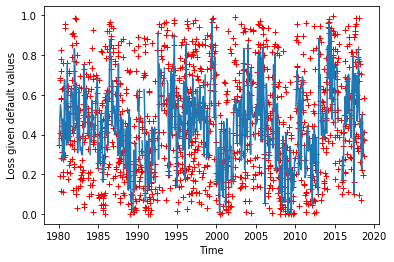

In [5]:
#creating a datetime for the plot
df['dates']=np.ones(len(df))
d={'Year':'Year','Month':'Month',"dates":"Day"}
vDate= pd.to_datetime(df.rename(columns=d)[list(d.values())]) 
df.index= vDate
        
# Plot of the data points per month with their mean 
sX = "vDate"
lY = df.columns.values[2:11]
sXlabel = "Time"
sYlabel = "Loss given default values"
sName = "Initial_data_descriptives"
vMean = df[lY].mean(axis=1)   
fnPlotData(sX,lY,df,sXlabel,sYlabel,sName,vMean)

In [4]:
def Characteristics(aVector):
    
    """
    Purpose:
      Compute certain characteristic of data in a vector 

    Inputs:
      aVector    an array of data
          
    Initialize:
    
      iMean     mean
      iMed      median
      iMin      minimum
      iMax      maximum
      iKurt     kurtosis  
      iSkew     skewness    
      iStd      standard deviation
         
    Return value:
      aResults  an array with calculated characteristics
    """

    iMin  =     aVector.min().values[0]
    iMax  =     aVector.max().values[0]
    iMean =     np.mean(aVector).values[0]
    iMed  =     np.median(aVector)
    iKurt =     st.kurtosis(aVector)[0]  
    iSkew =     st.skew(aVector)[0]    
    iStd  =     aVector.std().values[0] 
      
    aResults = np.array([iMin,iMax, iMean,iMed,iKurt,iSkew,iStd])
      
    return aResults

def CleanVector(df, lY):
    
    """
    Purpose:
    Create a vector of values for Characteristics function.

    Inputs:
     lY          list of names of relevant columns from df
     df          dataframe
          
    Initialize:
     vCon        vector of all the relevant colums without NaN's 
             
    Return value:
     vConNp       cleaned vector of values for Characteristics function 
    """
    
    # merging columns into one vector of dataframe
    vCon = df[lY[0]]

    for i in range(1,len(lY)):
        vCon = pd.concat([vCon,df[lY[i]]])
    
    # dropping NaNs
    vCon = vCon.dropna()
    
    # creating a NP array  
    vConNP = vCon.to_numpy()
    
    return (vConNP)

In [5]:
# a vector of values for descriptives
vdfNP = gas_est.CleanVector(df, lY)
# print table characteristics of average LGD per month, zeros are put in case of NaNs 
tVol = pd.DataFrame(columns = ["Minimum", "Maximum", "Mean", "Median", "Excess Kurtosis","Skewness","Standard Deviation"])
tVol.loc["Average LGD per month"] = gas_est.Characteristics(pd.DataFrame(vdfNP))

# Drop NAs
dfNaN= df[lY].mean(axis=1).dropna()
tVol.loc["Average LGD per month without NA"] = gas_est.Characteristics(pd.DataFrame(dfNaN))
print( "\n", tVol.T, "\n")


                     Average LGD per month  Average LGD per month without NA
Minimum                          0.000000                          0.002000
Maximum                          0.996000                          0.975500
Mean                             0.454941                          0.449182
Median                           0.436000                          0.451250
Excess Kurtosis                 -1.054567                         -0.298495
Skewness                         0.168052                          0.091952
Standard Deviation               0.268059                          0.194936 



The table shows the statistics of the LGD values throughout the period regardless the month the value occurred in as well as average LGD per month in months there was at least one LGD value. It happened twice that a company defaulted, but the credit loss was zero. The worst case happened in October 2014, where a creditor was able to regain only 0:4% of the remaining commitment. Mean and median are relatively close together, suggesting slightly positive skewness in both cases. However, excess kurtosis is more deviated from the normal distribution, showing that the data set has considerably
less values in tails - "light" tailed distribution.

## 4. Model Fitting

Now, we aim to fit the Beta-GAS model to our LGD data, according to the theorical setup presented above. The first step involves the derivation of the GAS model with the Beta distribution.

### 4.1 Derivation of the GAS model

Let $N_t$ denote the number of defaults observed at time (month) $t$ and denote $y_{i,t} \in (0,1)$ as the $i$-th LGD observation at time $t$ for $i=1,2...N_t$, where $i \in \{1, \dots N_t\}$. LGD values are independent within each month, so:

\begin{equation}
y_t| \mathscr{F}_{t-1} = \left\{ \begin{array}{r@{\quad}c}
    y_{i,t}| \mathscr{F}_{t-1} & \text{cross-sectionally independent} \\
    y_t| \mathscr{F}_{t-1} & \sim Beta(y_t|a_t,b_t). \\ \end{array} \right.
\end{equation}

The probability density function of the Beta distribution is given by the following expression:
\begin{equation}
p(y_{i,t}|b_t,\theta) = \frac{c\cdot\Gamma(a_t + b_t)}{\Gamma(a_t) \cdot \Gamma(b_t)}\cdot y_{i,t}^{c\cdot a_{t}-1}\cdot (1-y_{i,t}^{c})^{b_{t}-1},
 \end{equation}
 
where $a_t = s\cdot \mu_t$ , $b_t = s\cdot(1-\mu_t)$ and $s,c >0$.

We set $\mu_t =\frac{1}{1 + e^{-f_t}}$. The partial derivative with respect to $f_t$ is

$$\frac{\partial \mu_t}{\partial f_t} = \frac{e^{-f_t}}{(1 + e^{-f_t})^2} = \frac{e^{f_t}}{(1 + e^{f_t})^2} = \mu_t \cdot (1-\mu_t)$$
 
As a next step, the partial derivative of the logarithm of the Beta distribution with respect to $f_t$ is taken:

$$
\begin{aligned}
\nabla_{i,t} =& \frac{\partial}{\partial f_t}\log{Beta(y_{i,t}|a_t,b_t)} = \frac{\partial}{\partial f_t} \log{\left( \frac{c \cdot \Gamma(a_t + b_t)}{\Gamma(a_t) \cdot \Gamma(b_t)}\cdot y_{i,t}^{c\cdot a_{t}-1}\cdot (1-y_{i,t}^{c})^{b_{t}-1} \right )}
\end{aligned}
$$

In the following equation, we derive $\nabla_{t}$ to compute the scaled score of the conditional model distribution:

$$
\begin{aligned}
\nabla_{t} =& \frac{\partial}{\partial f_t} \log{p(y_{1,t}, \dots, y_{N_t,t} |a_t,b_t}) =  \frac{\partial}{\partial f_t}\log{{\displaystyle \prod_{i=1}^{N_t}Beta(y_{i,t}|a_t,b_t)}} \\
 =& \frac{\partial}{\partial f_t}{\displaystyle \sum_{i=1}^{N_t} \log{Beta(y_{i,t}|a_t,b_t)}} = {\displaystyle \sum_{i=1}^{N_t} \nabla_{i,t} }
\end{aligned}
$$

Now, we arrive at our score, which is the direction of steps we are going to take and thus it will move the time
varying parameter. With these results we are able to take the Loglikelihood contribution

$$log p(y_{i,t} | f_t, \mathscr{F}_{t-1}; \theta) = \log{\left(c\cdot\Gamma(a_t + b_t) \right)} - \log{\left(\Gamma(a_t) \right)} - \log{\left(\Gamma(b_t) \right)} + (c\cdot a_{t}-1) \cdot \log{\left(y_{i,t} \right)} + (b_{t}-1) \cdot \log{\left((1-y_{i,t}^c) \right)}$$

We proceed with the partial derivation of the score $\nabla_{i,t}$:

$$
\begin{aligned}
\nabla_{i,t} &=  \frac{\partial log p(y_{i,t} | f_t, \mathscr{F}_{t-1}; \theta)}{\partial f_t} \\
 &= \left( \frac {\partial \log{\left(c \cdot \Gamma(a_t + b_t) \right)}}{ \partial {(a_t +b_t)}} \cdot \frac{(a_t +b_t)}{\mu_t} \cdot \frac{\mu_t}{f_t} \right) 
- \left( \frac{\partial \log{\left(\Gamma(a_t) \right)}}{\partial a_t} \cdot \frac{\partial a_t}{\partial \mu_t} \cdot \frac{\partial \mu_t}{\partial f_t} \right)  \\
 &- \left( \frac{\partial \log{\left(\Gamma(b_t) \right)}}{\partial b_t} \cdot \frac{\partial b_t}{\partial \mu_t} \cdot \frac{\partial \mu_t}{\partial f_t} \right) 
 + \left( \frac{\partial(c \cdot a_{t}-1) \cdot \log{\left(y_{i,t} \right)}}{\partial \mu_t} \cdot \frac{\partial \mu_t}{\partial f_t} \right) \\
 &+ \left( \frac{\partial(b_{t}-1) \cdot \log{\left((1-y_{i,t}^c  \right)}}{\partial \mu_t}\cdot \frac{\partial \mu_t}{\partial f_t} \right) \\
\end{aligned}
$$ 

Then

$$\nabla_{i,t}  = 0 - \phi(a_t) \cdot s \cdot \mu_t \cdot (1-\mu_t) + \phi(b_t) \cdot s \cdot \mu_t \cdot (1-\mu_t) c \cdot \log(y_{i,t}) \cdot s \cdot \mu_t \cdot (1-\mu_t) -\log(1 - y_{i,t}^c) \cdot s \cdot \mu_t \cdot (1-\mu_t)$$

Finally,
\begin{equation}
\begin{aligned}
\nabla_t  =& \displaystyle \sum_{i=1}^{N_t} \left[ s \cdot \mu_t \cdot (1-\mu_t) \cdot ( - \phi(a_t) + \phi(b_t) + c \cdot \log(y_{i,t}) -\log(1 - y_{i,t}^c) ) \right].
\end{aligned}
\end{equation} 

Scaling the score by $S_t= {N_t}^{-1}$, we receive the final scaled score of the conditional model distribution:

$$
s_t = S_t \cdot \nabla_{t} 
= \frac{1}{{N_t}} \displaystyle \sum_{i=1}^{N_t} \Biggl\{s \cdot \frac{e^{f_t}}{(1 + e^{f_t})^2} \cdot \Biggl[-\phi\left(s \cdot \frac{1}{1 + e^{-f_t}} \right) +\phi\left( 1- \frac{1}{1 + e^{-f_t}} \right) + c \cdot \log(y_{i,t}) -\log(1 - y_{i,t}^c) \Biggl] \Biggr\}. 
$$

Obtaining the formula for $s_t$, the time varying parameter in the **GAS(1,1)** model is updated:

$$f_{t+1}  = \omega + \beta f_{t} + \alpha s_t$$

### 4.2 Implementation

We estimate $\theta = (\omega, \alpha, \beta, s, c)$ by obtaining the transition equation for $f_{t+1}$ recursively and maximizing the Log-Likelihood via Prediction Error Decomposition given $f_1, \dots, f_T$. The following function computes the time varying parameters and Log-Likelihood contributions.

In [6]:
def fnGASfilter(aData, aParams):
    
    # parameters, which will be finally estimated by ML
    dOmega = aParams[0] 
    dAlpha = aParams[1]
    dBeta = aParams[2]
    dS = aParams[3]
    dC = aParams[4]
    
    # data, which is used for the observation driven model
    dfY = aData.values
    
    # initialize size
    iT = aData.shape[0]   

    # Initialize vector of loglikelihood contributions
    aLogllcontrib = np.zeros(iT)
    dM = np.nanmean(dfY.reshape((-1,1))) # mean of whole sample
    dF = np.log(dM / (1 - dM)) # starting value for time varying parameter
    aF = np.zeros(iT) # time varying parameter (in this case: mean)
    
    dScore = 0
    
    # filter variances and compute likelihood contributions by
    # a loop over the monthly observations    
    
    aA = np.zeros(iT)
    aB = np.zeros(iT)
    
    for t in range(iT):
        aMonth = aData.iloc[t].dropna().values # actual month
        aF[t] = dF
        dMu = np.exp(dF) / (1 + np.exp(dF))
        aA[t] = dS * dMu
        aB[t] = dS * (1 - dMu)
        
        if (aMonth.any() == True):
            
            # compute the likelihood contribution
            # partial derivative of the conditional distribution (Beta)
            aLogllcontrib[t] = np.sum(np.log(dC) + scs.gammaln(aA[t]+aB[t]) -\
                         scs.gammaln(aA[t]) - scs.gammaln(aB[t]) +\
                         (dC*aA[t]-1)*np.log(aMonth) +\
                         (aB[t]-1)*np.log(1-np.power(aMonth, dC)))
            # s_t = S_t * Nabla_t
            dScore = np.mean((dS*dMu*(1-dMu)) * (-scs.polygamma(0, aA[t]) + scs.polygamma(0, aB[t]) +\
                                                 dC * np.log(aMonth) - np.log(1-np.power(aMonth,dC))))
        
        # update the filter
        dF = dOmega + dBeta * dF + dAlpha * dScore
    
    return (aLogllcontrib, aF, aA, aB)

Running it gives us the time-varying parameters $f_1, \dots, f_T$, following the recipe in **2.2**. We use them to compute the Log Likelihood and to maximize it. 

To ensure a numerically stable Log-Likelihood maximization, we replace all LGD data values below $1\%$ by $0.01$ and all values above $99\%$ by $0.99$. 

In [7]:
def ReplaceValues(df, lY, iQ1, iQ2):
    
    """
    Purpose:
    Replace all values in dataframe below i1 by i1, and all values above i2 by i2.

    Inputs:
     lY          list of names of relevant columns from df
     df          dataframe
     i1          first value (lower boarder)
     i2          second value (upper boarder)
        
             
    Return value:
     dfClean     "windsorized" data frame
    """
    
    dfClean = df[lY]   
    dfClean = dfClean.clip(i1, i2)
   
    return (dfClean)

In [8]:
# replace all LGD values below 1% by 1%, and all values above 99% by 99%.
i1 = 0.01
i2 = 0.99

# df for GAS model
dfClean = ReplaceValues(df, lY, i1, i2)
print(dfClean)

             LGD1   LGD2   LGD3   LGD4   LGD5  LGD6  LGD7  LGD8  LGD9
1980-01-01    NaN    NaN    NaN    NaN    NaN   NaN   NaN   NaN   NaN
1980-02-01  0.349    NaN    NaN    NaN    NaN   NaN   NaN   NaN   NaN
1980-03-01  0.190  0.408  0.673  0.686    NaN   NaN   NaN   NaN   NaN
1980-04-01  0.718  0.783  0.282  0.585  0.381   NaN   NaN   NaN   NaN
1980-05-01  0.825  0.578  0.113    NaN    NaN   NaN   NaN   NaN   NaN
...           ...    ...    ...    ...    ...   ...   ...   ...   ...
2018-05-01  0.068  0.381  0.707    NaN    NaN   NaN   NaN   NaN   NaN
2018-06-01  0.221    NaN    NaN    NaN    NaN   NaN   NaN   NaN   NaN
2018-07-01  0.502    NaN    NaN    NaN    NaN   NaN   NaN   NaN   NaN
2018-08-01  0.377  0.197    NaN    NaN    NaN   NaN   NaN   NaN   NaN
2018-09-01  0.415  0.371  0.584  0.290    NaN   NaN   NaN   NaN   NaN

[465 rows x 9 columns]


The function `fnMaximizeLikelihood` below performs the **Log-Likelihood Maximization**.

We choose $f_1 = \log(\frac{m}{1-m})$ with $m$ being the overall sample average of $y_{i,t}$. Furthermore, to ensure that $\alpha,\beta \in (0,1)$, we use the reparameterization $\frac{1}{1+e^{-\alpha}}$ and $\frac{1}{1+e^{-\beta}}$. We force $c, s \in (0,5)$ by taking $\frac{5}{1+e^{-c}}$ and $\frac{5}{1+e^{-s}}$. Additionally, we force $\omega \in(0,1)$ by choosing $\frac{1}{1+e^{-\omega}}$. 

As starting values for the optimization procedure, we choose: $\omega = f_1$, the long term average of $f_t$, $\alpha = 0.25, \beta = 0.85, s = 2.5$ and $c = 2.5$. 

In [9]:
class cMaximizeLikelihood:
    def __init__(self):
        self.x0 = []
        self.x = []
        self.a =[]
        self.b = []
        self.tx0 = []
        self.tx = []
        self.likelihoodvalue = []
        self.tcovariancematrix = []
        self.covariancematrix = []
        self.filter = []
        self.success = False
        
def fnMaximizeLikelihood(aData):

    cReturnValue = cMaximizeLikelihood()

    def LOCAL_fParameterTransform(aTheta, bShapeAsVector=False):

        r = (
            (1/(1+np.exp(-aTheta[0]))),
            (1/(1+np.exp(-aTheta[1]))),
            (1/(1+np.exp(-aTheta[2]))),
            (5/(1+np.exp(-aTheta[3]))),
            (5/(1+np.exp(-aTheta[4])))
        )
        if (bShapeAsVector == True):
            return np.append([], r)
        else:
            return r
    
    def LOCAL_fObjective(vTheta, bForAllT=False):
        # initialize the parameter values
        dOmega, dAlpha, dBeta, dS, dC = LOCAL_fParameterTransform(vTheta)

        # run the filter
        (aLogllcontrib, aF, aA, aB) = fnGASfilter(aData, [dOmega, dAlpha, dBeta, dS, dC])
        
        cReturnValue.filter = aF
        cReturnValue.a = aA
        cReturnValue.b = aB
        
        dObjValue = -np.inf
        
        if (bForAllT == True):
            dObjValue = aLogllcontrib
        else:
            dObjValue = -np.mean(aLogllcontrib)
        
        return dObjValue
    
    def LOCAL_fComputeCovarianceMatrix(vTheta):
        # compute the inverse hessian of the average log likelihood
        mH= gd.hessian_2sided(LOCAL_fObjective, vTheta)
        mCov = np.linalg.inv(mH)
        mCov = (mCov + mCov.T)/2       #  Force to be symmetric
        # compute the outer product of gradients of the average log likelihood
        mG = gd.jacobian_2sided(LOCAL_fObjective, vTheta, True)
        mG = np.dot(mG.T, mG) / aData.shape[0]
        mG = np.dot(mG, mCov)
        mCov = np.dot(mCov, mG) / aData.shape[0]
        return mCov

    # initialize starting values and return value
    dfY = aData.values
    dM = np.nanmean(dfY.reshape((-1,1))) # mean of whole sample
    dF1 = np.log(dM / (1 - dM)) # starting value for time varying parameter
    vTheta = ([dF1, 0.25, 0.85, 2.5 ,2.5])
    cReturnValue.x0 = vTheta
    cReturnValue.tx0 = LOCAL_fParameterTransform(vTheta)
    
    # do the optimization
    tSol = minimize(LOCAL_fObjective, vTheta, method='BFGS', options={'disp': True, 'maxiter':250})
    cReturnValue.success = tSol['success']
    # check for success and store results
    if (tSol['success'] != True):
        print("*** no true convergence: ",tSol['message'])
    else:
        cReturnValue.x = tSol['x']
        cReturnValue.tx = LOCAL_fParameterTransform(cReturnValue.x)
        cReturnValue.likelihoodvalue = -aData.shape[0] * tSol['fun']
        cReturnValue.covariancematrix = LOCAL_fComputeCovarianceMatrix(cReturnValue.x)
        mJ = gd.jacobian_2sided(LOCAL_fParameterTransform, cReturnValue.x, True)
        cReturnValue.tcovariancematrix = np.dot(mJ, np.dot(cReturnValue.covariancematrix, mJ.T))
    
    return cReturnValue

### 4.3 Remarks

1. For the **Prediction Error Decomposition (PED)**, the conditional loglikelihood instead of the loglikelihood is considered. Consequently, the sum of the logarithm of the conditional distributions is computed using repeated conditioning. We omit the initial part of the likelihood and set the initial lagged disturbances equal to zero.
2. In order to maximize the conditional LogLikelihood, we minimize the negative average conditional LogLikelihood and use the `scipy.optimize` package. We optimize the *average* conditional Loglikelihood with the **Broyden – Fletcher – Goldfarb – Shanno** algorithm. This is motivated by the fact that in the Newton Raphson algorithm the Hessian might not be positive definite/invertible. In Quasi-Newton methods, the Hessian matrix is not computed. Instead, the Hessian matrix is approximated using updates specified by gradient evaluations. Optimizing for the average leads to a higher stability of the algorithm. Thus, the procedure is applied only for the sake of computational reasons.
3. While estimating parameters, we experience **convergence problems** due to a high sensitivity to initial values. A choice of a wrong starting value causes that the algorithm gets stuck in a local optimum. This results in a suboptimal value of the conditional Loglikelihood. Be choose the starting values by trying. Alternatively starting values for the optimizer can be chosen in the following way: (i) estimate the long-term mean of under the static version of the model and (ii) perform a grid search for the coefficients $\alpha$ and $\beta$.
4. We compute both, non-rubust standard errors of the estimates (inverse Hessian) as well as the robust ones (asymptotic sandwich estimator)

In [10]:
# Maximum Likelihood Estimation
y = fnMaximizeLikelihood(dfClean)

Optimization terminated successfully.
         Current function value: -0.270662
         Iterations: 71
         Function evaluations: 721
         Gradient evaluations: 103


## 5.Results (GAS(1,1) model)

The table shows parameter's estimates with their robust standard errors (obtained by the sandwich asymptotic covariance
matrix) in the brackets. The Log-Likelihood value of GAS($1$,$1$) model is $125.858$. With reparametrization,  $\hat{\alpha}_p, \hat{\beta}_p$, $\hat{\omega}_p \in (0,1)$ and $\hat{s}_p, \hat{c}_p \in (0,5)$.

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;}
.tg th{font-family:Arial, sans-serif;font-size:14px;font-weight:normal;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;}
.tg .tg-c3ow{border-color:inherit;text-align:center;vertical-align:top}
.tg .tg-0pky{border-color:inherit;text-align:left;vertical-align:top}
</style>
<table class="tg">
  <tr>
    <th class="tg-0pky"><b>Original</b></th>
    <th class="tg-c3ow">$\hat{\omega}$</th>
    <th class="tg-c3ow">$\hat{\alpha}$</th>
    <th class="tg-c3ow">$\hat{\beta}$</th>
    <th class="tg-c3ow">$\hat{s}$</th>
    <th class="tg-c3ow">$\hat{c}$</th>
  </tr>
  <tr>
    <td class="tg-0pky"></td>
    <td class="tg-c3ow">-5.987</td>
    <td class="tg-c3ow">-1.120</td>
    <td class="tg-c3ow">1.861</td>
    <td class="tg-c3ow">0.460</td>
    <td class="tg-c3ow">-1.600</td>
  </tr>
  <tr>
    <td class="tg-0pky"></td>
    <td class="tg-c3ow">(1.172)</td>
    <td class="tg-c3ow">(0.177)</td>
    <td class="tg-c3ow">(0.353)</td>
    <td class="tg-c3ow">(0.255)</td>
    <td class="tg-c3ow">(0.215)</td>
  </tr>
  <tr>
    <td class="tg-0pky"><b>Reparameterized</b></td>
    <td class="tg-c3ow">$\hat{\omega}_{p}$</td>
    <td class="tg-c3ow">$\hat{\alpha}_p$</td>
    <td class="tg-c3ow">$\hat{\beta}_p$</td>
    <td class="tg-c3ow">$\hat{s}_p$</td>
    <td class="tg-c3ow">$\hat{c}_p$</td>
  </tr>
  <tr>
    <td class="tg-0pky"></td>
    <td class="tg-c3ow">0.003</td>
    <td class="tg-c3ow">0.246</td>
    <td class="tg-c3ow">0.865</td>
    <td class="tg-c3ow">3.065</td>
    <td class="tg-c3ow">0.840</td>
  </tr>
  <tr>
    <td class="tg-0pky"></td>
    <td class="tg-c3ow">(0.028)</td>
    <td class="tg-c3ow">(0.033)</td>
    <td class="tg-c3ow">(0.041)</td>
    <td class="tg-c3ow">(0.303)</td>
    <td class="tg-c3ow">(0.150)</td>
  </tr>
</table>

We observe that the standard errors (obtained by the **delta method**) are considerably lower after the reparameterization procedure. The value of $\hat{\omega}$ is low as expected since we anticipated a low drift. Furthermore, we have a high $\hat{\beta}$ and a small $\hat{\alpha}$, because the parameters vary slowly over time. This implies a high dependence of the time varying parameter of past values and a small dependence on the scaled score.

In [11]:
print("Original Parameters omega, alpha, beta, s, c: ", y.x)
print("Likelihood: ", y.likelihoodvalue)
print("Original Parameters Standard Errors: ", np.sqrt(np.diag(y.covariancematrix)))
print("")
print("Reparameterized Parameters omega, alpha, beta, s, c: ", y.tx)
print(y.tcovariancematrix)
print("Reparameterized Parameters Standard Errors: ", np.sqrt(np.diag(y.tcovariancematrix)))

Original Parameters omega, alpha, beta, s, c:  [-5.98429667 -1.12019478  1.86062093  0.46030228 -1.59963194]
Likelihood:  125.85782486764673
Original Parameters Standard Errors:  [44.9917405   0.24328905  0.41145012  0.94352849  0.83845757]

Reparameterized Parameters omega, alpha, beta, s, c:  (0.002511659754714069, 0.2459751557522554, 0.8653693063964333, 3.06542941310145, 0.8401653163156302)
[[ 1.27058247e-02 -3.51914515e-03 -3.33469645e-03  1.24995700e-01
  -6.56948897e-02]
 [-3.51914515e-03  2.03609910e-03  5.78084531e-04 -3.56291704e-02
   1.85195049e-02]
 [-3.33469645e-03  5.78084531e-04  2.29787044e-03 -3.31422225e-02
   1.73092701e-02]
 [ 1.24995700e-01 -3.56291704e-02 -3.31422225e-02  1.25233878e+00
  -6.53202465e-01]
 [-6.56948897e-02  1.85195049e-02  1.73092701e-02 -6.53202465e-01
   3.43481868e-01]]
Reparameterized Parameters Standard Errors:  [0.11272012 0.04512315 0.04793611 1.11907944 0.58607326]


The figure below shows LGD values in the same fashion as the first figure of the Jupyter Notebook. However, the blue line depicts the GAS(1,1) model implied expected LGD (expected mean of the model distribution) per month and it is calculated as 

$$ mean_{t}  = \frac{\Gamma{(a_t + b_t)}}{\Gamma{(a_t)}} \cdot \frac{\Gamma{(a_t + c^{-1})}}{\Gamma{(a_t + c^{-1} + b_t)}}$$

This mean follows similar oscillations as the raw data mean, however it reaches values from $0.21$ to $0.68$, so it is more stable and less spiky in comparison to the mean in the first figure.

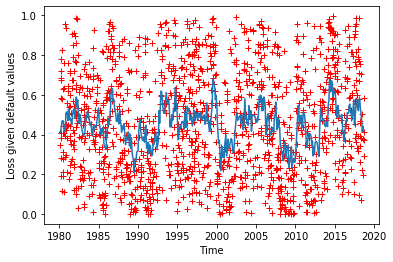

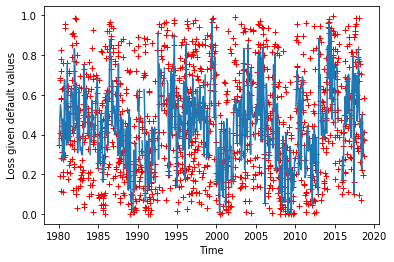

Min GAS mean: 0.2084430807236055
Max GAS mean: 0.6786269527079222


In [12]:
def fnMean(aA, aB, dC):
    
    mean = scs.gamma(aA + aB) * scs.gamma(aA + 1/dC) / scs.gamma(aA) / scs.gamma(aA + aB + 1/dC)
    
    return mean

sName2 = "GAS_data_descriptives"

df['vMeanGas']= fnMean(y.a, y.b, y.tx[-1])
fnPlotData(sX,lY,df,sXlabel,sYlabel,sName2,df['vMeanGas'])
vMean = df[lY].mean(axis=1)   
fnPlotData(sX,lY,df,sXlabel,sYlabel,sName,vMean)
print("Min GAS mean:", np.min(fnMean(y.a, y.b, y.tx[-1])))  
print("Max GAS mean:", np.max(fnMean(y.a, y.b, y.tx[-1])))